In [69]:
from IPython.display import clear_output
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt
import registration as reg
import SimpleITK as sitk
import numpy as np
import utils as ut
import importlib

In [2]:
COMMON_PATH = "../data/COMMON_images_masks/common_"
GROUP_PATH = "../data/g3_"

# 1.Data Exploration

In [21]:
importlib.reload(ut)
filename = COMMON_PATH + '40_image.nii.gz'
maskname = COMMON_PATH + '40_mask.nii.gz' 
pelvic_img = ut.read_image(filename)
pelvic_mask = ut.read_image(maskname)

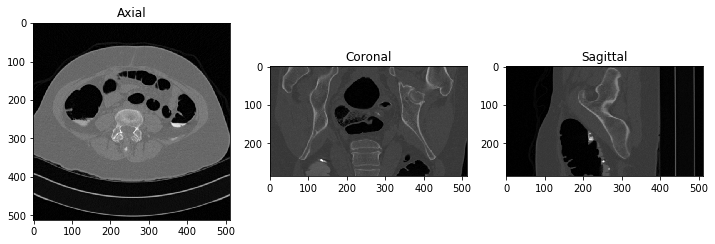

In [20]:
ut.plot_3d_img_slices(pelvic_img)

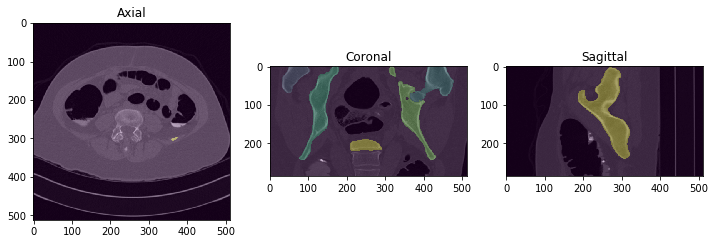

In [22]:
ut.plot_3d_img_masked(pelvic_img, pelvic_mask)

### Select only mask of interest (1 Right femur and 3 Right hip bone)

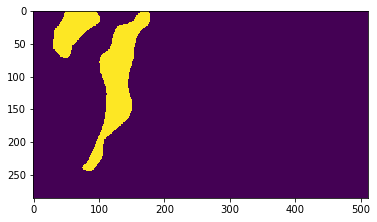

In [64]:
fix_mask_1 = (pelvic_mask == 1)
fix_mask_3 = (pelvic_mask == 3)
fix_mask = fix_mask_1 + fix_mask_3
fix_mask.GetSize()
fix_mask_data = sitk.GetArrayFromImage(fix_mask)
plt.imshow(fix_mask_data[:,256,:])

## 1.2 Explore a Fixed and Moving Image

In [25]:
moving_image_file_name = COMMON_PATH + '42_image.nii.gz'
fixed_image = pelvic_img
moving_image = ut.read_image(moving_image_file_name)

In [27]:
importlib.reload(ut)
interact(ut.display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=142, description='fixed_image_z', max=285), IntSlider(value=145, descrip…

In [28]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(ut.display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled))

interactive(children=(IntSlider(value=142, description='image_z', max=285), FloatSlider(value=0.5, description…

<function utils.display_images_with_alpha(image_z, alpha, fixed, moving)>

# 3. Registration
## Linear Trasform: Affine Transformation 12DOF

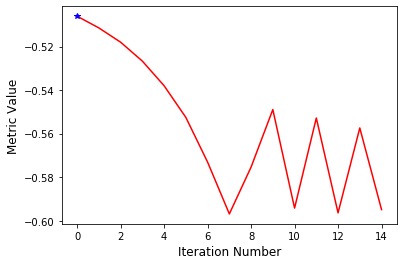

itk::simple::Transform
 CompositeTransform (0000020A62D9E520)
   RTTI typeinfo:   class itk::CompositeTransform<double,3>
   Reference Count: 1
   Modified Time: 10565279
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   AffineTransform (0000020A0339FB80)
     RTTI typeinfo:   class itk::AffineTransform<double,3>
     Reference Count: 1
     Modified Time: 10565120
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       1.00449 0.00670605 0.000119993 
       0.0223839 1.01476 0.0025053 
       -0.00033165 0.0011885 1.00269 
     Offset: [-7.89189, -3.489, -1188.05]
     Center: [1, -129, 842.698]
     Translation: [-8.65136, -3.26, -1185.93]
     Inverse: 
       0.99568 -0.00657981 -0.000102714 
       -0.0219638 0.985599 -0.00245996 
       0.000355364 -0.00117042 0.997317 
     Singular: 0
   End of MultiTransform.
<<<<<<<<<<
   TransformsToOptimizeFlags, begin() to end(): 
      1 
   Tran

In [99]:
%%time
importlib.reload(reg)
im_mov_filename = COMMON_PATH + '41_image.nii.gz'
im_ref_filename = COMMON_PATH + '40_image.nii.gz'
lin_trf = reg.LinearTransform(im_ref_filename=im_ref_filename,im_mov_filename=im_mov_filename)
lin_xfm = lin_trf.est_transf()

In [100]:
moving_image = lin_trf.im_mov
fixed_image = lin_trf.im_ref
interact(ut.display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=142, description='fixed_image_z', max=285), IntSlider(value=149, descrip…

In [101]:
moving_image = lin_trf.apply_transf(lin_xfm)
fixed_image = lin_trf.im_mov
interact(ut.display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=149, description='fixed_image_z', max=299), IntSlider(value=142, descrip…

In [102]:
fixed_image = lin_trf.im_ref
moving_image = lin_trf.apply_transf(lin_xfm)
interact(ut.display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=142, description='fixed_image_z', max=285), IntSlider(value=142, descrip…

In [104]:
moving_resampled = lin_trf.apply_transf(lin_xfm)
fixed_image = lin_trf.im_ref
interact(ut.display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled))

interactive(children=(IntSlider(value=142, description='image_z', max=285), FloatSlider(value=0.5, description…

<function utils.display_images_with_alpha(image_z, alpha, fixed, moving)>

## Non Linear Transformation  FFD 

In [107]:
%%time
importlib.reload(reg)
im_mov_filename = COMMON_PATH + '41_image.nii.gz'
im_ref_filename = COMMON_PATH + '40_image.nii.gz'
non_lin_trf = reg.NonLinearTransform(im_ref_filename=im_ref_filename,im_mov_filename=im_mov_filename)
non_lin_xfm = non_lin_trf.est_transf()

RuntimeError: Exception thrown in SimpleITK ImageRegistrationMethod_Execute: d:\a\1\work\b\itk-prefix\include\itk-5.1\itkMattesMutualInformationImageToImageMetricv4.hxx:316:
itk::ERROR: itk::ERROR: MattesMutualInformationImageToImageMetricv4(0000020A62BC0950): All samples map outside moving image buffer. The images do not sufficiently overlap. They need to be initialized to have more overlap before this metric will work. For instance, you can align the image centers by translation.
